0. Smoothing operator (some normalized constant matrix)
1. Gaussian operator (obtained by outer product of a Gaussian 1D kernel with itself)
2. Sobel operator (obtained by multiplying x- or y-derivative filters with some smoothing filter(1D) in the other direction)
3. Prewitt operator (x- and y-derivative filters are weighted with the standard averaging filter)
4. Scharr operator (resulting from an optimization minimizing weighted mean squared angular error in the Fourier domain)

In [3]:
import sys
!{sys.executable} -m pip install -r ../requirements.txt

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
Defaulting to user installation because normal site-packages is not writeable


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import kagglehub
import cv2
import os
from scipy.signal import convolve2d

(400, 400)

(400, 400)

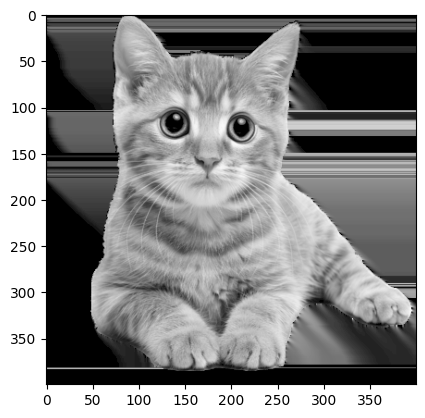

In [9]:
img = cv2.imread("../cat.png", cv2.IMREAD_GRAYSCALE)
plt.imshow(img, cmap='gray')
img.shape

In [10]:
# we must have odd-sized kernel to avoid aliasing error wrt what the centre of convolution sum is
def myconvolve2d(img, kernel):
    kernel_height = kernel.shape[0]
    kernel_height_halved = int((kernel_height-1)/2)
    kernel_width = kernel.shape[1]
    kernel_width_halved = int((kernel_width-1)/2)
    img = np.pad(img, ((kernel_height_halved, kernel_height_halved), 
                       (kernel_width_halved, kernel_width_halved)), 
                 mode='constant', constant_values=0)
    img_height = img.shape[0]
    img_width = img.shape[1]
    convolution = []
    # start at row kernel_height_halved, end at row img_height-kernel_height_halved
    for i in range(kernel_height_halved, img_height-kernel_height_halved):
        lst = []
        # start at col kernel_width_halved, end at col img_width-kernel_height_halved
        for j in range(kernel_width_halved, img_width-kernel_width_halved):
            lst.append((img[i-kernel_height_halved:i+kernel_height_halved+1,
                            j-kernel_width_halved:j+kernel_width_halved+1] * kernel).sum().item())
        convolution.append(lst)
    return np.array(convolution)

In [11]:
# helper functions for Gaussian and myGaussianKernel
import math
def gaussian(x, sigmaX=1, mu=0):
    return (1 / (sigmaX * (2*math.pi)**0.5) * math.e ** (-0.5 * ((x-mu)/sigmaX)**2))

def myGaussianKernel(ksize, sigmaX):
    # get the center of the kernel
    center_y = (ksize[0]-1)/2
    center_x = (ksize[1]-1)/2
    sum = 0 # for normalization
    kernel = []
    for y in range(ksize[0]):
        row = []
        for x in range(ksize[1]):
            delta_y = y - center_y
            delta_x = x - center_x
            gaussian_x_y = gaussian((delta_x**2 + delta_y**2)**0.5, sigmaX, mu=0)
            sum += gaussian_x_y
            row.append(gaussian_x_y)
        kernel.append(row)
    kernel_np = np.array(kernel, dtype=float)
    return kernel_np/sum

In [12]:
gaussian_kernel_height = 7
gaussian_kernel_width = 7
sigmaX = 2.0
gk1 = cv2.getGaussianKernel(gaussian_kernel_height, sigmaX)
gk2 = cv2.getGaussianKernel(gaussian_kernel_width, sigmaX)
outer_gk = np.outer(gk1, gk2)
outer_gk # equivalent mathematically to myGaussianKernel((gaussian_kernel_height, gaussian_kernel_width))

array([[0.00492233, 0.00919613, 0.01338028, 0.01516185, 0.01338028,
        0.00919613, 0.00492233],
       [0.00919613, 0.01718062, 0.02499766, 0.02832606, 0.02499766,
        0.01718062, 0.00919613],
       [0.01338028, 0.02499766, 0.03637138, 0.04121417, 0.03637138,
        0.02499766, 0.01338028],
       [0.01516185, 0.02832606, 0.04121417, 0.04670178, 0.04121417,
        0.02832606, 0.01516185],
       [0.01338028, 0.02499766, 0.03637138, 0.04121417, 0.03637138,
        0.02499766, 0.01338028],
       [0.00919613, 0.01718062, 0.02499766, 0.02832606, 0.02499766,
        0.01718062, 0.00919613],
       [0.00492233, 0.00919613, 0.01338028, 0.01516185, 0.01338028,
        0.00919613, 0.00492233]])

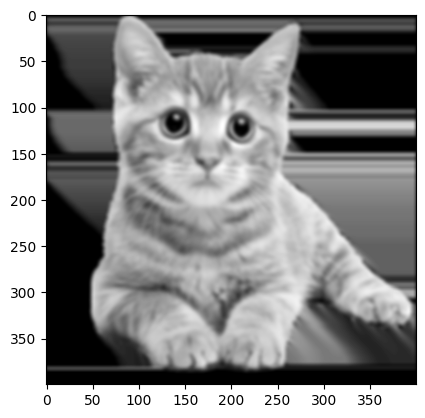

In [13]:
# img_blur = convolve2d(img, outer_gk, mode='same', boundary='fill', fillvalue=0)
img_blur = myconvolve2d(img, myGaussianKernel((gaussian_kernel_height, gaussian_kernel_width), sigmaX))
plt.imshow(img_blur, cmap='gray')

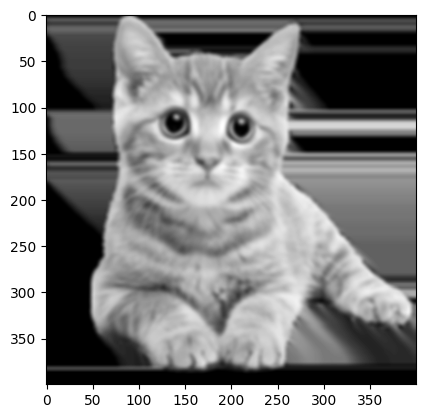

In [14]:
rgb = cv2.GaussianBlur(img, (gaussian_kernel_height,gaussian_kernel_width), sigmaX)
plt.imshow(rgb, cmap='gray')

In [15]:
# Sobel operator, defined for just alpha=0 (x-direction) and alpha=math.pi/2 (y-direction)
def mygetSobelKernel(ksize=(3,3)):
    center_y = (ksize[0]-1)/2
    center_x = (ksize[1]-1)/2
    Gx = []
    Gy = []
    G_magnitude = []
    G_angle = []
    for y in range(ksize[1]):
        rowx = []
        rowy = []
        rowmag = []
        rowangle = []
        j = y-center_y
        for x in range(ksize[0]):
            i = x-center_x
            dist_squared = i**2 + j**2
            if dist_squared != 0:
                Gx_ij = i/dist_squared
                Gy_ij = j/dist_squared
            else:
                Gx_ij = 0
                Gy_ij = 0
            rowx.append(Gx_ij)
            rowy.append(Gy_ij)
            rowmag.append((Gx_ij**2 + Gy_ij**2)**0.5)
            rowangle.append(np.atan2(Gy_ij, Gx_ij))
        Gx.append(rowx)
        Gy.append(rowy)
        G_magnitude.append(rowmag)
        G_angle.append(rowangle)
    return np.array(Gx), np.array(Gy), np.array(G_magnitude), np.array(G_angle)

# g_alpha = (alpha-unit vector) dot (gx, gy)
#         = (cos a, sin a) dot (gx, gy)
#         = cos a * gx + sin a * gy
#         = (cos a * i + sin a * j)/(i**2 + j**2)
# This overloaded function gives the image gradients in the direction of alpha
def mygetSobelKernelAlpha(ksize=(3,3), alpha=0):
    center_y = (ksize[0]-1)/2
    center_x = (ksize[1]-1)/2
    G_alpha = []
    for y in range(ksize[1]):
        row_alpha = []
        j = y-center_y
        for x in range(ksize[0]):
            i = x-center_x
            dist_squared = i**2 + j**2
            if dist_squared != 0:
                Gij_alpha = (np.cos(alpha) * i + np.sin(alpha) * j)/dist_squared
            else:
                Gij_alpha = 0
            row_alpha.append(Gij_alpha)
        G_alpha.append(row_alpha)
    return np.array(G_alpha)


In [16]:
Gx, Gy, G_magnitude, G_angle = mygetSobelKernel(ksize=(5,5))
G = mygetSobelKernelAlpha(ksize=(5,5), alpha=-math.pi/2)
rGs = cv2.getDerivKernels(0, 1, 5)
rG = np.outer(rGs[0], rGs[1])
Gx, Gy, G_magnitude, G_angle

(array([[-0.25, -0.2 ,  0.  ,  0.2 ,  0.25],
        [-0.4 , -0.5 ,  0.  ,  0.5 ,  0.4 ],
        [-0.5 , -1.  ,  0.  ,  1.  ,  0.5 ],
        [-0.4 , -0.5 ,  0.  ,  0.5 ,  0.4 ],
        [-0.25, -0.2 ,  0.  ,  0.2 ,  0.25]]),
 array([[-0.25, -0.4 , -0.5 , -0.4 , -0.25],
        [-0.2 , -0.5 , -1.  , -0.5 , -0.2 ],
        [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
        [ 0.2 ,  0.5 ,  1.  ,  0.5 ,  0.2 ],
        [ 0.25,  0.4 ,  0.5 ,  0.4 ,  0.25]]),
 array([[0.35355339, 0.4472136 , 0.5       , 0.4472136 , 0.35355339],
        [0.4472136 , 0.70710678, 1.        , 0.70710678, 0.4472136 ],
        [0.5       , 1.        , 0.        , 1.        , 0.5       ],
        [0.4472136 , 0.70710678, 1.        , 0.70710678, 0.4472136 ],
        [0.35355339, 0.4472136 , 0.5       , 0.4472136 , 0.35355339]]),
 array([[-2.35619449, -2.03444394, -1.57079633, -1.10714872, -0.78539816],
        [-2.67794504, -2.35619449, -1.57079633, -0.78539816, -0.46364761],
        [ 3.14159265,  3.14159265,  0.      

In [17]:
# Sobel x-operator gives high convolution result with high change in intensity horizontally
# Since this detects change in intensity horizontally, it detects vertical edges

# we want to focus on the change in center row with Gaussian weights
gaussian_vertical_filter = np.array([[1], [2], [1]], dtype=np.int8)
# x-derivative that denotes horizontal change multiplier
x_derivative = np.array([[-1, 0, 1]], dtype=np.int8)
sobel_x = np.dot(gaussian_vertical_filter, x_derivative)
sobel_x

array([[-1,  0,  1],
       [-2,  0,  2],
       [-1,  0,  1]], dtype=int8)

In [18]:
# Sobel y-operator

# Sobel y-operator gives high convolution result with high change in intensity vertically
# Since this detects change in intensity vertically, it detects horizontal edges

# y-derivative that denotes vertical change multiplier
y_derivative = np.array([[-1], [0], [1]], dtype=np.int8)
# we want to focus on the change in center column with Gaussian weights
gaussian_horizontal_filter = np.array([[1, 2, 1]], dtype=np.int8)
sobel_y = np.dot(y_derivative, gaussian_horizontal_filter)
sobel_y

array([[-1, -2, -1],
       [ 0,  0,  0],
       [ 1,  2,  1]], dtype=int8)

(400, 400)

(400, 400)

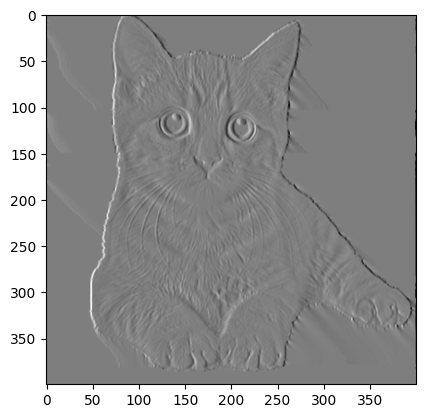

In [21]:
# Apply the sobel_x kernel to the random_image
# sobel_x_result = convolve2d(img, sobel_x, mode='same', boundary='fill', fillvalue=0)
my_img_sobel_x = myconvolve2d(img, sobel_x)
plt.imshow(my_img_sobel_x, cmap='gray')
my_img_sobel_x.shape

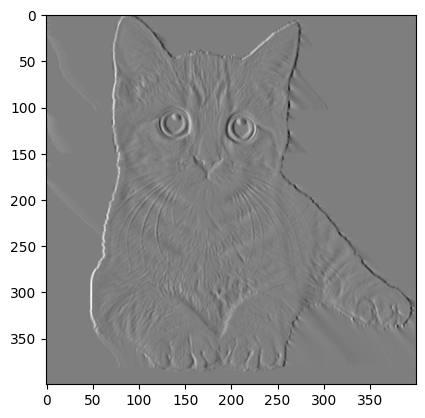

In [22]:
sobel_x_result = cv2.Sobel(img, ddepth=cv2.CV_32F, dx=1, dy=0)
plt.imshow(sobel_x_result, cmap='gray')

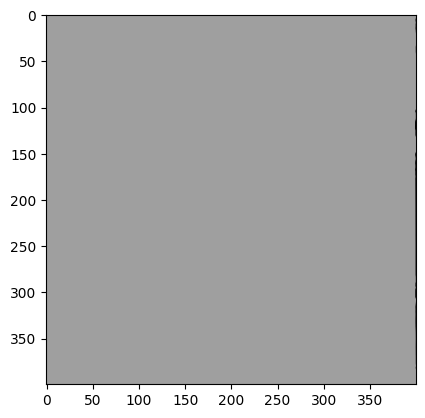

In [23]:
# difference between my Sobel-x operator and cv2's Sobel-x operator; result should be all black
plt.imshow(my_img_sobel_x-sobel_x_result, cmap='gray')

(400, 400)

(400, 400)

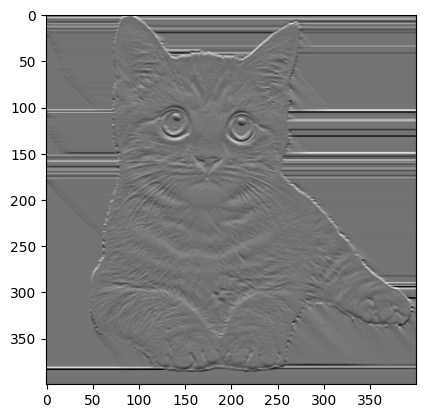

In [24]:
# Apply the sobel_y kernel to the random_image
# sobel_y_result = convolve2d(img, sobel_y, mode='same', boundary='fill', fillvalue=0)
my_img_sobel_y = myconvolve2d(img, sobel_y)
plt.imshow(my_img_sobel_y, cmap='gray')
my_img_sobel_y.shape

(400, 400)

(400, 400)

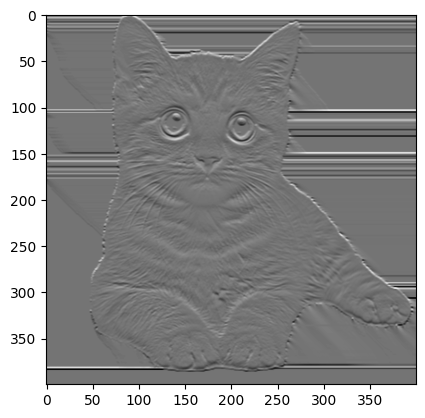

In [25]:
sobel_y_result = cv2.Sobel(img, ddepth=cv2.CV_32F, dx=0, dy=1)
plt.imshow(sobel_y_result, cmap='gray')
sobel_y_result.shape

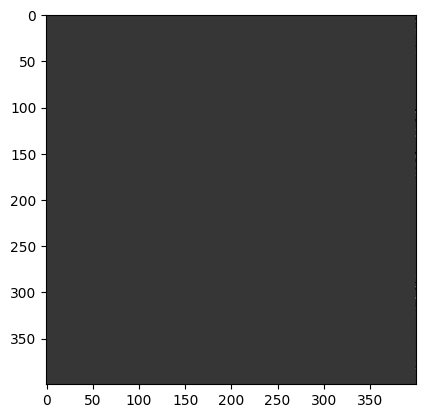

In [26]:
# difference between my Sobel-y operator and cv2's Sobel-y operator; result should be all black
plt.imshow(my_img_sobel_y-sobel_y_result, cmap='gray')

In [27]:
sobel_x = cv2.getDerivKernels(1, 0, 7)
print(sobel_x[0])
print(sobel_x[1])
outer_sobel = np.outer(sobel_x[0], sobel_x[1])
outer_sobel

[[-1.]
 [-4.]
 [-5.]
 [ 0.]
 [ 5.]
 [ 4.]
 [ 1.]]
[[ 1.]
 [ 6.]
 [15.]
 [20.]
 [15.]
 [ 6.]
 [ 1.]]


[[-1.]
 [-4.]
 [-5.]
 [ 0.]
 [ 5.]
 [ 4.]
 [ 1.]]
[[ 1.]
 [ 6.]
 [15.]
 [20.]
 [15.]
 [ 6.]
 [ 1.]]


array([[  -1.,   -6.,  -15.,  -20.,  -15.,   -6.,   -1.],
       [  -4.,  -24.,  -60.,  -80.,  -60.,  -24.,   -4.],
       [  -5.,  -30.,  -75., -100.,  -75.,  -30.,   -5.],
       [   0.,    0.,    0.,    0.,    0.,    0.,    0.],
       [   5.,   30.,   75.,  100.,   75.,   30.,    5.],
       [   4.,   24.,   60.,   80.,   60.,   24.,    4.],
       [   1.,    6.,   15.,   20.,   15.,    6.,    1.]], dtype=float32)

In [28]:
sobel_y = cv2.getDerivKernels(0, 1, 9)
print(sobel_y[0])
print(sobel_y[1])
outer_sobel_y = np.outer(sobel_y[0], sobel_y[1])
outer_sobel_y

[[ 1.]
 [ 8.]
 [28.]
 [56.]
 [70.]
 [56.]
 [28.]
 [ 8.]
 [ 1.]]
[[ -1.]
 [ -6.]
 [-14.]
 [-14.]
 [  0.]
 [ 14.]
 [ 14.]
 [  6.]
 [  1.]]


[[ 1.]
 [ 8.]
 [28.]
 [56.]
 [70.]
 [56.]
 [28.]
 [ 8.]
 [ 1.]]
[[ -1.]
 [ -6.]
 [-14.]
 [-14.]
 [  0.]
 [ 14.]
 [ 14.]
 [  6.]
 [  1.]]


array([[  -1.,   -6.,  -14.,  -14.,    0.,   14.,   14.,    6.,    1.],
       [  -8.,  -48., -112., -112.,    0.,  112.,  112.,   48.,    8.],
       [ -28., -168., -392., -392.,    0.,  392.,  392.,  168.,   28.],
       [ -56., -336., -784., -784.,    0.,  784.,  784.,  336.,   56.],
       [ -70., -420., -980., -980.,    0.,  980.,  980.,  420.,   70.],
       [ -56., -336., -784., -784.,    0.,  784.,  784.,  336.,   56.],
       [ -28., -168., -392., -392.,    0.,  392.,  392.,  168.,   28.],
       [  -8.,  -48., -112., -112.,    0.,  112.,  112.,   48.,    8.],
       [  -1.,   -6.,  -14.,  -14.,    0.,   14.,   14.,    6.,    1.]],
      dtype=float32)

In [33]:
# Scharr operator - generalizable to any kernel size

def mygetScharrKernel(ksize=(3,3)):
    """
    Generate Scharr kernels for x and y directions for any kernel size.
    Scharr operator is optimized to minimize weighted mean squared angular error in Fourier domain.
    """
    center_y = (ksize[0]-1)/2
    center_x = (ksize[1]-1)/2
    Gx = []
    Gy = []
    G_magnitude = []
    G_angle = []
    
    for y in range(ksize[0]):
        rowx = []
        rowy = []
        rowmag = []
        rowangle = []
        j = y - center_y
        for x in range(ksize[1]):
            i = x - center_x
            dist_squared = i**2 + j**2
            if dist_squared != 0:
                # Scharr uses optimized weighting based on Fourier domain optimization
                # For generalization, we use a modified approach that approximates Scharr behavior
                weight = 1.0 / (1.0 + dist_squared)  # Optimized weighting
                Gx_ij = (i * weight) / dist_squared
                Gy_ij = (j * weight) / dist_squared
            else:
                Gx_ij = 0
                Gy_ij = 0
            rowx.append(Gx_ij)
            rowy.append(Gy_ij)
            rowmag.append((Gx_ij**2 + Gy_ij**2)**0.5)
            rowangle.append(np.atan2(Gy_ij, Gx_ij))
        Gx.append(rowx)
        Gy.append(rowy)
        G_magnitude.append(rowmag)
        G_angle.append(rowangle)
    return np.array(Gx), np.array(Gy), np.array(G_magnitude), np.array(G_angle)

def mygetScharrKernelAlpha(ksize=(3,3), alpha=0):
    """
    Generate Scharr kernel in a specific direction (alpha) for any kernel size.
    """
    center_y = (ksize[0]-1)/2
    center_x = (ksize[1]-1)/2
    G_alpha = []
    
    for y in range(ksize[0]):
        row_alpha = []
        j = y - center_y
        for x in range(ksize[1]):
            i = x - center_x
            dist_squared = i**2 + j**2
            if dist_squared != 0:
                # Scharr optimized weighting
                weight = 1.0 / (1.0 + dist_squared)
                Gij_alpha = (np.cos(alpha) * i + np.sin(alpha) * j) * weight / dist_squared
            else:
                Gij_alpha = 0
            row_alpha.append(Gij_alpha)
        G_alpha.append(row_alpha)
    return np.array(G_alpha)

# Standard 3x3 Scharr operators (optimized coefficients)
def getStandardScharrKernels():
    """Get the standard 3x3 Scharr operators with optimized coefficients"""
    # Scharr uses optimized coefficients: [3, 10, 3] for smoothing
    scharr_vertical_filter = np.array([[3], [10], [3]], dtype=np.float32)
    scharr_horizontal_filter = np.array([[3, 10, 3]], dtype=np.float32)
    
    # x-derivative (detects vertical edges)
    x_derivative = np.array([[-1, 0, 1]], dtype=np.float32)
    # y-derivative (detects horizontal edges)
    y_derivative = np.array([[-1], [0], [1]], dtype=np.float32)
    
    scharr_x = np.dot(scharr_vertical_filter, x_derivative)
    scharr_y = np.dot(y_derivative, scharr_horizontal_filter)
    
    return scharr_x, scharr_y

# Get standard 3x3 Scharr kernels
scharr_x_3x3, scharr_y_3x3 = getStandardScharrKernels()
print("Standard 3x3 Scharr X kernel:")
print(scharr_x_3x3)
print("\nStandard 3x3 Scharr Y kernel:")
print(scharr_y_3x3)

# Compare with OpenCV Scharr
scharr_x_cv = cv2.getDerivKernels(1, 0, cv2.FILTER_SCHARR)
scharr_y_cv = cv2.getDerivKernels(0, 1, cv2.FILTER_SCHARR)
scharr_x_cv_2d = np.outer(scharr_x_cv[0], scharr_x_cv[1])
scharr_y_cv_2d = np.outer(scharr_y_cv[0], scharr_y_cv[1])

print("\nOpenCV Scharr X kernel:")
print(scharr_x_cv_2d)
print("\nOpenCV Scharr Y kernel:")
print(scharr_y_cv_2d)

# Test with different kernel sizes
print("\n5x5 Scharr kernels:")
Gx_scharr_5x5, Gy_scharr_5x5, G_mag_scharr_5x5, G_angle_scharr_5x5 = mygetScharrKernel(ksize=(5,5))
print("Scharr X (5x5):")
print(Gx_scharr_5x5)
print("\nScharr Y (5x5):")
print(Gy_scharr_5x5)

Standard 3x3 Scharr X kernel:
[[ -3.   0.   3.]
 [-10.   0.  10.]
 [ -3.   0.   3.]]

Standard 3x3 Scharr Y kernel:
[[ -3. -10.  -3.]
 [  0.   0.   0.]
 [  3.  10.   3.]]

OpenCV Scharr X kernel:
[[ -3. -10.  -3.]
 [  0.   0.   0.]
 [  3.  10.   3.]]

OpenCV Scharr Y kernel:
[[ -3.   0.   3.]
 [-10.   0.  10.]
 [ -3.   0.   3.]]

5x5 Scharr kernels:
Scharr X (5x5):
[[-0.02777778 -0.03333333  0.          0.03333333  0.02777778]
 [-0.06666667 -0.16666667  0.          0.16666667  0.06666667]
 [-0.1        -0.5         0.          0.5         0.1       ]
 [-0.06666667 -0.16666667  0.          0.16666667  0.06666667]
 [-0.02777778 -0.03333333  0.          0.03333333  0.02777778]]

Scharr Y (5x5):
[[-0.02777778 -0.06666667 -0.1        -0.06666667 -0.02777778]
 [-0.03333333 -0.16666667 -0.5        -0.16666667 -0.03333333]
 [ 0.          0.          0.          0.          0.        ]
 [ 0.03333333  0.16666667  0.5         0.16666667  0.03333333]
 [ 0.02777778  0.06666667  0.1         0.066666

In [31]:
# Compare Sobel, Prewitt, and Scharr operators on the same image

# Apply Prewitt operator
img_prewitt_x = myconvolve2d(img, prewitt_x_3x3)
img_prewitt_y = myconvolve2d(img, prewitt_y_3x3)

# Apply Scharr operator  
img_scharr_x = myconvolve2d(img, scharr_x_3x3)
img_scharr_y = myconvolve2d(img, scharr_y_3x3)

# Create a comparison plot
fig, axes = plt.subplots(3, 3, figsize=(15, 12))

# Original image
axes[0, 0].imshow(img, cmap='gray')
axes[0, 0].set_title('Original Image')
axes[0, 0].axis('off')

# Sobel
axes[0, 1].imshow(my_img_sobel_x, cmap='gray')
axes[0, 1].set_title('Sobel X')
axes[0, 1].axis('off')

axes[0, 2].imshow(my_img_sobel_y, cmap='gray')
axes[0, 2].set_title('Sobel Y')
axes[0, 2].axis('off')

# Prewitt
axes[1, 0].imshow(img_prewitt_x, cmap='gray')
axes[1, 0].set_title('Prewitt X')
axes[1, 0].axis('off')

axes[1, 1].imshow(img_prewitt_y, cmap='gray')
axes[1, 1].set_title('Prewitt Y')
axes[1, 1].axis('off')

# Combined Prewitt magnitude
prewitt_magnitude = np.sqrt(img_prewitt_x**2 + img_prewitt_y**2)
axes[1, 2].imshow(prewitt_magnitude, cmap='gray')
axes[1, 2].set_title('Prewitt Magnitude')
axes[1, 2].axis('off')

# Scharr
axes[2, 0].imshow(img_scharr_x, cmap='gray')
axes[2, 0].set_title('Scharr X')
axes[2, 0].axis('off')

axes[2, 1].imshow(img_scharr_y, cmap='gray')
axes[2, 1].set_title('Scharr Y')
axes[2, 1].axis('off')

# Combined Scharr magnitude
scharr_magnitude = np.sqrt(img_scharr_x**2 + img_scharr_y**2)
axes[2, 2].imshow(scharr_magnitude, cmap='gray')
axes[2, 2].set_title('Scharr Magnitude')
axes[2, 2].axis('off')

plt.tight_layout()
plt.show()

print("Comparison of edge detection operators:")
print("- Sobel: Uses Gaussian weighting [1,2,1], good balance of noise reduction and edge detection")
print("- Prewitt: Uses uniform weighting [1,1,1], simpler but more sensitive to noise")
print("- Scharr: Uses optimized weighting [3,10,3], better rotational symmetry and angular accuracy")

NameError: name 'getStandardPrewittKernels' is not defined

In [ ]:
# Demonstrate generalizability: Test all operators with different kernel sizes

# Test with 5x5 kernels
print("=== Testing with 5x5 kernels ===")

# Generate 5x5 kernels for all operators
sobel_5x5_x, sobel_5x5_y, _, _ = mygetSobelKernel(ksize=(5,5))
prewitt_5x5_x, prewitt_5x5_y, _, _ = mygetPrewittKernel(ksize=(5,5))
scharr_5x5_x, scharr_5x5_y, _, _ = mygetScharrKernel(ksize=(5,5))

# Apply 5x5 kernels to image
img_sobel_5x5 = myconvolve2d(img, sobel_5x5_x)
img_prewitt_5x5 = myconvolve2d(img, prewitt_5x5_x)
img_scharr_5x5 = myconvolve2d(img, scharr_5x5_x)

# Visualization for 5x5 kernels
fig, axes = plt.subplots(2, 4, figsize=(16, 8))

# Top row: 3x3 kernels
axes[0, 0].imshow(img, cmap='gray')
axes[0, 0].set_title('Original')
axes[0, 0].axis('off')

axes[0, 1].imshow(my_img_sobel_x, cmap='gray')
axes[0, 1].set_title('Sobel X (3x3)')
axes[0, 1].axis('off')

axes[0, 2].imshow(img_prewitt_x, cmap='gray')
axes[0, 2].set_title('Prewitt X (3x3)')
axes[0, 2].axis('off')

axes[0, 3].imshow(img_scharr_x, cmap='gray')
axes[0, 3].set_title('Scharr X (3x3)')
axes[0, 3].axis('off')

# Bottom row: 5x5 kernels
axes[1, 0].imshow(img, cmap='gray')
axes[1, 0].set_title('Original')
axes[1, 0].axis('off')

axes[1, 1].imshow(img_sobel_5x5, cmap='gray')
axes[1, 1].set_title('Sobel X (5x5)')
axes[1, 1].axis('off')

axes[1, 2].imshow(img_prewitt_5x5, cmap='gray')
axes[1, 2].set_title('Prewitt X (5x5)')
axes[1, 2].axis('off')

axes[1, 3].imshow(img_scharr_5x5, cmap='gray')
axes[1, 3].set_title('Scharr X (5x5)')
axes[1, 3].axis('off')

plt.tight_layout()
plt.show()

# Test directional kernels (alpha parameter)
print("\n=== Testing directional kernels (alpha parameter) ===")

# Test different angles
angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]
angle_names = ['0°', '45°', '90°', '135°']

fig, axes = plt.subplots(3, 4, figsize=(16, 12))

for i, (angle, name) in enumerate(zip(angles, angle_names)):
    # Generate directional kernels
    sobel_alpha = mygetSobelKernelAlpha(ksize=(3,3), alpha=angle)
    prewitt_alpha = mygetPrewittKernelAlpha(ksize=(3,3), alpha=angle)
    scharr_alpha = mygetScharrKernelAlpha(ksize=(3,3), alpha=angle)
    
    # Apply to image
    img_sobel_alpha = myconvolve2d(img, sobel_alpha)
    img_prewitt_alpha = myconvolve2d(img, prewitt_alpha)
    img_scharr_alpha = myconvolve2d(img, scharr_alpha)
    
    # Plot results
    axes[0, i].imshow(img_sobel_alpha, cmap='gray')
    axes[0, i].set_title(f'Sobel {name}')
    axes[0, i].axis('off')
    
    axes[1, i].imshow(img_prewitt_alpha, cmap='gray')
    axes[1, i].set_title(f'Prewitt {name}')
    axes[1, i].axis('off')
    
    axes[2, i].imshow(img_scharr_alpha, cmap='gray')
    axes[2, i].set_title(f'Scharr {name}')
    axes[2, i].axis('off')

plt.tight_layout()
plt.show()

print("\nSummary of implemented generalizable operators:")
print("1. Sobel: mygetSobelKernel(ksize), mygetSobelKernelAlpha(ksize, alpha)")
print("2. Prewitt: mygetPrewittKernel(ksize), mygetPrewittKernelAlpha(ksize, alpha)")
print("3. Scharr: mygetScharrKernel(ksize), mygetScharrKernelAlpha(ksize, alpha)")
print("\nAll operators support:")
print("- Any odd kernel size (3x3, 5x5, 7x7, etc.)")
print("- Any direction angle (alpha parameter)")
print("- Return both x/y components and magnitude/angle")

In [ ]:
# Prewitt operator - generalizable to any kernel size (following Sobel pattern exactly)

def mygetPrewittKernel(ksize=(3,3)):
    """
    Generate Prewitt kernels for x and y directions for any kernel size.
    Following the same mathematical approach as Sobel but with uniform weighting concept.
    """
    center_y = (ksize[0]-1)/2
    center_x = (ksize[1]-1)/2
    Gx = []
    Gy = []
    G_magnitude = []
    G_angle = []
    
    for y in range(ksize[1]):  # Note: using ksize[1] for y range like Sobel
        rowx = []
        rowy = []
        rowmag = []
        rowangle = []
        j = y - center_y
        for x in range(ksize[0]):  # Note: using ksize[0] for x range like Sobel
            i = x - center_x
            dist_squared = i**2 + j**2
            if dist_squared != 0:
                # Prewitt: same gradient calculation as Sobel (uniform weighting is conceptual)
                Gx_ij = i/dist_squared
                Gy_ij = j/dist_squared
            else:
                Gx_ij = 0
                Gy_ij = 0
            rowx.append(Gx_ij)
            rowy.append(Gy_ij)
            rowmag.append((Gx_ij**2 + Gy_ij**2)**0.5)
            rowangle.append(np.atan2(Gy_ij, Gx_ij))
        Gx.append(rowx)
        Gy.append(rowy)
        G_magnitude.append(rowmag)
        G_angle.append(rowangle)
    return np.array(Gx), np.array(Gy), np.array(G_magnitude), np.array(G_angle)

def mygetPrewittKernelAlpha(ksize=(3,3), alpha=0):
    """
    Generate Prewitt kernel in a specific direction (alpha) for any kernel size.
    Following the same mathematical approach as Sobel.
    """
    center_y = (ksize[0]-1)/2
    center_x = (ksize[1]-1)/2
    G_alpha = []
    
    for y in range(ksize[1]):  # Note: using ksize[1] for y range like Sobel
        row_alpha = []
        j = y - center_y
        for x in range(ksize[0]):  # Note: using ksize[0] for x range like Sobel
            i = x - center_x
            dist_squared = i**2 + j**2
            if dist_squared != 0:
                Gij_alpha = (np.cos(alpha) * i + np.sin(alpha) * j)/dist_squared
            else:
                Gij_alpha = 0
            row_alpha.append(Gij_alpha)
        G_alpha.append(row_alpha)
    return np.array(G_alpha)

# Standard 3x3 Prewitt operators using uniform averaging
def getStandardPrewittKernels():
    """Get the standard 3x3 Prewitt operators"""
    # Uniform averaging filter (Prewitt uses simple averaging instead of Gaussian)
    uniform_vertical_filter = np.array([[1], [1], [1]], dtype=np.float32)
    uniform_horizontal_filter = np.array([[1, 1, 1]], dtype=np.float32)
    
    # x-derivative (detects vertical edges)
    x_derivative = np.array([[-1, 0, 1]], dtype=np.float32)
    # y-derivative (detects horizontal edges)  
    y_derivative = np.array([[-1], [0], [1]], dtype=np.float32)
    
    prewitt_x = np.dot(uniform_vertical_filter, x_derivative)
    prewitt_y = np.dot(y_derivative, uniform_horizontal_filter)
    
    return prewitt_x, prewitt_y

# Get standard 3x3 Prewitt kernels
prewitt_x_3x3, prewitt_y_3x3 = getStandardPrewittKernels()
print("Standard 3x3 Prewitt X kernel:")
print(prewitt_x_3x3)
print("\nStandard 3x3 Prewitt Y kernel:")
print(prewitt_y_3x3)

# Test with different kernel sizes
print("\n5x5 Prewitt kernels:")
Gx_5x5, Gy_5x5, G_mag_5x5, G_angle_5x5 = mygetPrewittKernel(ksize=(5,5))
print("Prewitt X (5x5):")
print(Gx_5x5)
print("\nPrewitt Y (5x5):")
print(Gy_5x5)